In [2]:
!pip install fpdf
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI

from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langchain.agents import AgentExecutor
from typing_extensions import Annotated, TypedDict
from typing import Callable, Literal, Optional, Sequence, Type, TypeVar, Union, cast, List, Tuple, Any
from langchain_core.messages import AIMessage, BaseMessage, SystemMessage, ToolMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.tools import tool
import json
from fpdf import FPDF
import datetime

In [3]:
from sql_react_agent_llama import SQL_SUBAGENT, make_dataframe
from viz_agent import VIZ_AGENT
from initiate_llm import gpt_llm, llama_llm

import pandas as pd

##### Agent State and Setup

In [ ]:
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    question: Annotated[str, Field(description="The user question")]
    sql_query: Annotated[str, Field(description="The SQL query generated by the agent")]
    results: List[List[Union[int, float, str, bool]]] = Field(..., description="The results returned by the SQL agent as a list of tuples.")
    df: pd.DataFrame = Field(..., description="The table returned by the make_table node as a pandas dataframe.")
    python_visualization_code: Annotated[str, Field(description="The Python code to visualize the results")]

##### SQL Sub-agent

In [5]:
def nl2sql_node(state: AgentState) -> Command[Literal["supervisor"]]:
    last = state['messages'][-1]
    question = last.content
    try:
        question = json.loads(question)
        question = question["question"]
    except json.JSONDecodeError:
        pass        
    result = SQL_SUBAGENT.invoke({"messages": [HumanMessage(content=last.content)]})
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="sql_agent")
            ],
            "question": question,
            "sql_query": json.loads(result["messages"][-1].content)['query'],
            "results": json.loads(result["messages"][-1].content)['result'],
        },
        goto="supervisor",
    )

##### Make table node

In [6]:
def make_table_node(state: AgentState) -> Command[Literal["supervisor"]]:
    query = state["sql_query"]
    results = state["results"]
    df = make_dataframe(query, results)
    return Command(
        update={
            "messages": [
                HumanMessage(content=f"Here is the table I created from the results: {str(df)}", name="make_table")
            ],
            "df": df,
        },
        goto="supervisor",
    )

#### Visualization Node

In [7]:
def viz_node(state: AgentState) -> Command[Literal["supervisor"]]:
    question = state["question"]
    df = state["df"]
    results = state["results"]
    viz_agent_state = {
        "question": question,
        "df": df,
        "results": results,
        "messages": [],
        "error": ""
    }

    response = VIZ_AGENT.invoke(viz_agent_state)
    viz_code = response["generation"].imports + "\n" + response["generation"].code
    return Command(
        update={
            "messages": [
                HumanMessage(content=f"Here is the visualization code for plotting the data:\n {viz_code}", name="viz_agent"),
            ],
            "python_visualization_code": viz_code,
        },
        goto="supervisor",
    )

#### Setting up Supervisor and Report Generation

In [8]:
members = ["sql_agent", "make_table", "viz_agent"]
options = members + ["generate_report"]

In [9]:
supervisor_prompt = (
    """
    You are a supervisor agent named "SQLOrchestrator" tasked with managing the following workers: {members}.

    Your job is to orchestrate a multi-step pipeline to answer the user's question stored in `AgentState.question`. Examine the current `AgentState` fields and decide the next worker based on the following strict rules:

    1. **SQL Generation & Execution**  
       - If `AgentState.results` is empty, an empty string, or not populated with query results, route to `sql_agent`.  
       - The `sql_agent` generates `AgentState.sql_query`, executes it, and populates `AgentState.results` with a list of result tuples.

    2. **Table Construction**  
       - After `results` is populated (i.e., contains a non-empty list of result tuples), if `AgentState.df` is empty, an empty string, or marked as '<not populated>', route to `make_table`.  
       - The `make_table` node converts `AgentState.results` into a pandas DataFrame and populates `AgentState.df`.

    3. **Visualization Code**  
       - After `df` is populated (i.e., contains a DataFrame with data, marked as '<DataFrame populated>'), if `AgentState.python_visualization_code` is empty or an empty string, route to `viz_agent`.  
       - The `viz_agent` generates Python visualization code and populates `AgentState.python_visualization_code`.

    4. **Generate Report & Respond**  
       - After `results`, `df`, and `python_visualization_code` are all populated (i.e., `results` is a non-empty list, `df` is '<DataFrame populated>', and `python_visualization_code` is a non-empty string), route to `generate_report`.  
       - For `generate_report`, provide a final answer summarizing `AgentState.df` and referencing `AgentState.python_visualization_code`, then generate a PDF report.

    **Important Instructions**:
    - Always follow the full pipeline (`sql_agent` -> `make_table` -> `viz_agent` -> `generate_report`) unless the user explicitly requests only a subset (e.g., 'only generate the table').
    - Even if the user mentions 'generate a report', assume visualization is required unless explicitly excluded.
    - Treat `AgentState.df` as populated only if it is marked as '<DataFrame populated>' in the state.
    - Do not skip steps or route to `generate_report` early unless all conditions (non-empty `results`, populated `df`, non-empty `python_visualization_code`) are met.
    - If unsure, prioritize the next logical step in the sequence over premature termination.
    """
)

In [10]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to generate_report - AND give the final answer."""
    next: Literal["sql_agent", "make_table_node", "viz_agent", "generate_report"]
    final_answer: str

In [11]:
def supervisor_node(state: AgentState) -> Command[Literal["sql_agent", "make_table_node", "viz_agent", "generate_report"]]:
    def serialize_state(obj):
        if isinstance(obj, pd.DataFrame):
            return "<DataFrame populated>" if not obj.empty else "<not populated>"
        return str(obj)

    messages = [
        {"role": "system", "content": supervisor_prompt.format(members=members)},
    ] + state["messages"]
    print("\n\n========BACK TO SUPERVISOR========\n")

    state_info = {k: v for k, v in state.items() if k != 'messages'}
    serialized_state = json.dumps(state_info, default=serialize_state)

    messages = [
        {"role": "system", "content": supervisor_prompt.format(members=members)},
        {"role": "user", "content": f"AgentState: {serialized_state}"}
    ] + state["messages"]
    
    print("INVOKING WITH STATE INFO\n", serialized_state)
    response = gpt_llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    print(f"LLM Response: {response}")
    if goto == "generate_report":
        return Command(
            update={
                "messages": [
                    HumanMessage(content=response["final_answer"], name="supervisor")
                ]
            },
            goto="generate_report"
        )
    return Command(goto=goto)

In [12]:
import os
def generate_report(state: AgentState):
    print("Starting PDF generation...")
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="Conversation Report", ln=True, align='C')
    
    for msg in state["messages"]:
        if isinstance(msg, BaseMessage):
            speaker = msg.name if msg.name else "Unknown"
            content = msg.content
            pdf.cell(200, 10, txt=f"{speaker}: {content}", ln=True)
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"report_{timestamp}.pdf"
    pdf.output(filename)
    print(f"Report saved as {filename} in {os.getcwd()}")

In [13]:
def generate_report_node(state: AgentState) -> Command[Literal["__end__"]]:
    generate_report(state)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"report_{timestamp}.pdf"
    return Command(
        update={
            "messages": [
                AIMessage(content=f"Report has been generated and saved as {filename}", name="generate_report")
            ]
        },
        goto=END
    )

In [14]:
builder = StateGraph(AgentState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("sql_agent", nl2sql_node)
builder.add_node("make_table_node", make_table_node)
builder.add_node("viz_agent", viz_node)
builder.add_node("generate_report", generate_report_node)
graph = builder.compile()

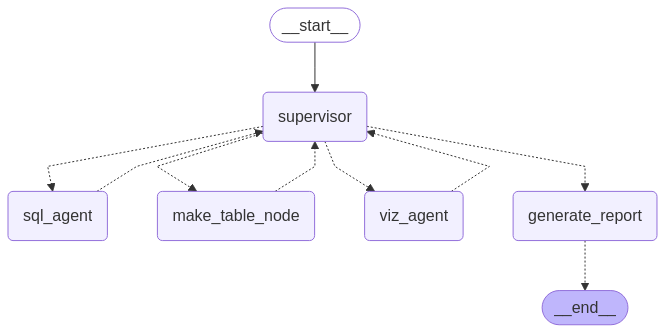

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(str(e))
    pass

In [ ]:
initial_state = {
    "messages": [HumanMessage(content="Give me the number of employees present from each ethnicity")],
    "question": "",
    "sql_query": "",
    "results": "",
    "df": "",
    "python_visualization_code": ""
}

result = graph.invoke(initial_state)



========BACK TO SUPERVISOR========

INVOKING WITH STATE INFO
 {"question": "", "sql_query": "", "results": "", "df": "", "python_visualization_code": "", "is_df_populated": false, "is_viz_code_generated": false}
Next Worker: sql_agent
LLM Response: {'next': 'sql_agent', 'final_answer': ''}


=======IN SQL TOOL WITH ==> Give me the number of employees present from each ethnicity

>>>QUERY WAS ==>  SELECT "ethnic_description", COUNT("employee_id") FROM analytical_schema.dim_ukg_employee_demographic_details GROUP BY "ethnic_description" LIMIT 5


=======IN EXEC SQL NODE WITH ==> {'question': 'Give me the number of employees present from each ethnicity', 'query': 'SELECT "ethnic_description", COUNT("employee_id") FROM analytical_schema.dim_ukg_employee_demographic_details GROUP BY "ethnic_description" LIMIT 5'}
Query Execution Result: [('Hispanic or Latino', 81), ('Native American', 57), ('Asian', 67), ('White', 74), (None, 144)]

>>>UPDATED STATE WAS ==>  {'question': 'Give me the numbe

In [ ]:
# Test cell for generating report from the last conversation
last_conversation = {
    "messages": [HumanMessage(content="Give me the number of employees for each ethnicity and generate me a report")],
    "question": "",
    "sql_query": "",
    "results": "",
    "df": "",
    "python_visualization_code": ""
}

test_result = graph.invoke(last_conversation)
print("Test Result:", test_result)
print(f"Final messages: {test_result['messages']}")
# Verify the PDF was generated by checking the output message
for msg in test_result['messages']:
    if 'Report has been generated' in msg.content:
        print(f"PDF Generation Confirmation: {msg.content}")



========BACK TO SUPERVISOR========

INVOKING WITH STATE INFO
 {"question": "", "sql_query": "", "results": "", "df": "", "python_visualization_code": "", "is_df_populated": false, "is_viz_code_generated": false}
Next Worker: sql_agent
LLM Response: {'next': 'sql_agent', 'final_answer': ''}


=======IN SQL TOOL WITH ==> Give me the number of employees for each ethnicity and generate me a report

>>>QUERY WAS ==>  SELECT "ethnic_description", COUNT("employee_id") FROM analytical_schema.dim_ukg_employee_demographic_details GROUP BY "ethnic_description" LIMIT 5;


=======IN EXEC SQL NODE WITH ==> {'question': 'Give me the number of employees for each ethnicity and generate me a report', 'query': 'SELECT "ethnic_description", COUNT("employee_id") FROM analytical_schema.dim_ukg_employee_demographic_details GROUP BY "ethnic_description" LIMIT 5;'}
Query Execution Result: [('Hispanic or Latino', 81), ('Native American', 57), ('Asian', 67), ('White', 74), (None, 144)]

>>>UPDATED STATE WAS ==